In [1]:
import numpy as np
import pandas as pd
import pycountry
import matplotlib.pyplot as plt
%matplotlib inline

We load the StackOverflow survey data, and add a more convenient Country columns, named `LOCATION`, using ISO alpha-3 codes.

In [2]:
def lookup_country(x):
    """
    Description: Lookup alpha-3 country code, failing silently if not found.
    This is needed because the pycountry functions throw an exception if no
    country is found.
    
    Arguments:
        x: a country name (as a string)
    
    Returns:
        The ISO alpha-3 code for the country, or None if country not found
    """
    try:
        return pycountry.countries.lookup(x).alpha_3
    except:
        return None

YEAR = 2018
SALARY_FIELD = 'ConvertedSalary'
df_surv = pd.read_csv('SODS{}/survey_results_public.csv'.format(YEAR))
df_surv['Pay'] = df_surv[SALARY_FIELD]
df_surv['LOCATION'] = df_surv['Country'].apply(lookup_country)

/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We focus on those countries where at least 500 respondents report a salary and full-time employment status.


In [3]:
num_respondents = df_surv['LOCATION'].value_counts()

num_salaries = df_surv[(df_surv['Employment'] == 'Employed full-time')
                  & (df_surv['Pay'].notnull())]['LOCATION'].value_counts()

interesting_countries = list(num_salaries[num_salaries >= 500].index)

In [4]:
interesting_countries

['USA',
 'IND',
 'GBR',
 'DEU',
 'CAN',
 'FRA',
 'AUS',
 'RUS',
 'BRA',
 'ESP',
 'NLD',
 'POL',
 'ITA',
 'SWE']

# Countries and salaries

Compute the purchasing power parity (PPP) factors.

In [5]:
exchange_rate = pd.read_csv('exchange.csv')
ppp = pd.read_csv('ppp.csv')
df_currency = exchange_rate[['LOCATION', 'TIME', 'Value']]\
    .rename(columns={'Value': 'EXCH'})\
    .merge(ppp[['LOCATION', 'TIME', 'Value']]\
           .rename(columns={'Value': 'PPP'}),
           on = ['LOCATION', 'TIME'])
df_currency['PPPFactor'] = df_currency['EXCH'] / df_currency['PPP']

Now we load the OECD income data, select the most recent median income figure. This wans't used in the end, because it is for disposable income, and we don't have this information form the SO survey.

In [6]:
idd = pd.read_csv('IDD_26112019171956454.csv')
df_pay = idd[(idd['MEASURE'] == 'MEDIANC') & (idd['AGE'] == 'WA')]\
    .sort_values('TIME')\
    .drop_duplicates(subset=['LOCATION'])\
    [['LOCATION', 'TIME', 'Unit Code', 'Value']]\
    .rename(columns={'Value': 'MedianIncomeLC'})\
    .merge(df_currency, how='left', on=['LOCATION', 'TIME'])\
    .merge(df_currency[df_currency['TIME'] == 2018][['LOCATION', 'PPPFactor']]\
           .rename(columns={'PPPFactor': 'PPPFactor2018'}),
           on = 'LOCATION')
df_pay['NatMedian']\
    = df_pay['MedianIncomeLC'] / df_pay['EXCH']
df_pay = df_pay.merge(
    df_surv.groupby('LOCATION')['Pay'].median().rename('SOMedian'),
    on = 'LOCATION')
df_pay = df_pay.merge(
    df_surv.groupby('LOCATION')['Pay'].mean().rename('SOMean'),
    on = 'LOCATION')
df_pay['NatMedianPPP']\
    = df_pay['NatMedian'] * df_pay['PPPFactor']
df_pay['SOMedianPPP']\
    = df_pay['SOMedian'] * df_pay['PPPFactor2018']

Now we load the Gallup survey median income data.  This was just copied from Wikipedia, since it's not available as CSV or through an API.  The data is originanlly PPP-adjusted, so we compute also the unadjusted version.

In [7]:
gallup_medians = pd.Series({
 'USA': 43585,
 'IND':  3168,
 'GBR': 31617,
 'DEU': 33333,
 'CAN': 41280,
 'FRA': 31112,
 'RUS': 11724,
 'AUS': 46555,
 'BRA':  7522,
 'NLD': 38584,
 'ESP': 21959,
 'POL': 15338,
 'ITA': 20085,
 'SWE': 50514,
}, name='GallupMedianPPP')

df_pay = df_pay.merge(
    gallup_medians, left_on='LOCATION', right_index=True)
df_pay['GallupMedian'] = df_pay['GallupMedianPPP']\
    / df_pay['PPPFactor2018']
    
# Compute ratios between the national and the developer median salaries
df_pay['Ratio']\
    = df_pay['SOMedian'] / df_pay['NatMedian']
df_pay['RatioGalup']\
    = df_pay['SOMedian'] / df_pay['GallupMedian']

Below are some computations of means of SO salary data, dropping everything above a certain (0.95) quatile.  I also didn't use this information for the blog, because it didn't seem a meaninful comparison.

In [8]:
means = {}
for loc in interesting_countries:
    salaries = df_surv[df_surv['LOCATION'] == loc]['Pay']
    lim = salaries.quantile(0.95)
    means[loc] = salaries[salaries < lim].mean()

df_pay = df_pay.merge(
    pd.Series(means, name='SOMeanAdj'), left_on='LOCATION', right_index=True)

In [9]:
def plot_pay(y, save_as=None, countries=interesting_countries):
    """
    Plot columns of the df_pay dataframe as bar plots.
    
    Arguments:
        y: a list of column names from df_pay
        save_as: if given, the file name to save the plot
        countries: a list of countries to compare.  By default, use interesting_countries
    
    Returns:
        None
    """
    df_pay[df_pay['LOCATION'].isin(countries)]\
        .sort_values(y[0])\
        .plot.barh(x='LOCATION', y=y)
    if save_as:
        plt.savefig(save_as)

Several plots using the dataframes contructed

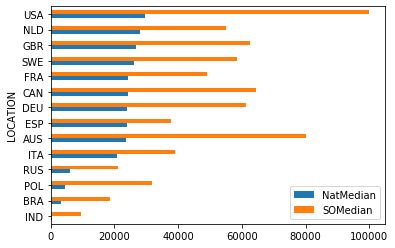

In [10]:
plot_pay(['NatMedian', 'SOMedian'])

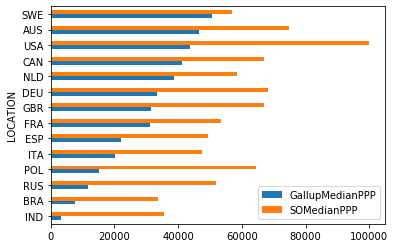

In [11]:
plot_pay(['GallupMedianPPP', 'SOMedianPPP'], 'median-salaries-ppp.png')

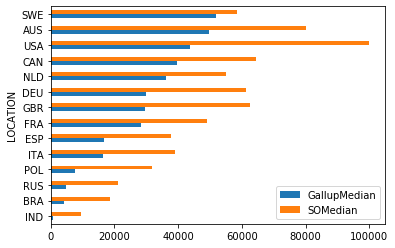

In [12]:
plot_pay(['GallupMedian', 'SOMedian'], 'median-salaries.png')

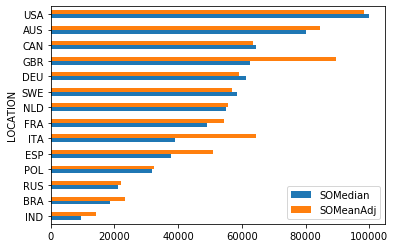

In [13]:
plot_pay(['SOMedian', 'SOMeanAdj'])

# Wage gap

First we compute the ratio of male respondents

In [14]:
df_surv['IsMale'] = (df_surv['Gender'] == 'Male')
gender_ratios = df_surv[df_surv['Gender'].notnull()]\
    .groupby('LOCATION')['IsMale']\
    .mean()[interesting_countries]

Load OECD data

In [15]:
oecd_wagegap = pd.read_csv('gendergap.csv')
oecd_wagegap = oecd_wagegap[oecd_wagegap['SUBJECT'] == 'EMPLOYEE'].sort_values(
    'TIME',ascending=False).drop_duplicates('LOCATION').sort_values(
        'Value')[['LOCATION', 'Value']]

Compute the wage gap

In [16]:
so_median_male = df_surv[(df_surv['Gender'] == 'Male')
                    & (df_surv['Employment'] == 'Employed full-time')]\
                    .groupby('LOCATION')['Pay']\
                    .median()
so_enough_female = df_surv[(df_surv['Gender'] == 'Female')
                      & (df_surv['Employment'] == 'Employed full-time')]\
                      .groupby('LOCATION')['Pay'].count() >= 30
so_median_female = df_surv[(df_surv['Gender'] == 'Female')
                      & (df_surv['Employment'] == 'Employed full-time')]\
                      .groupby('LOCATION')['Pay'].median()\
                      [so_enough_female]
so_wagegap = (100*(so_median_male - so_median_female)/so_median_male)\
    .rename('WageGap')\
    .dropna()

df_wg = oecd_wagegap.merge(so_wagegap, left_on='LOCATION', right_on='LOCATION', how='inner')


Plot a graph

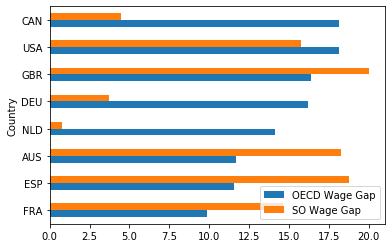

In [17]:
wagegap_plot = df_wg.sort_values('Value').plot.barh(x='LOCATION')
wagegap_plot.legend(['OECD Wage Gap', 'SO Wage Gap'])
wagegap_plot.set_ylabel('Country')
plt.savefig('wage-gap.png')

# Job satisfaction

Compute fraction of satisfied and extremely satisfied respondents by country

In [18]:
df_satisf = pd.DataFrame(index=interesting_countries)

for loc in interesting_countries:
    total = df_surv[df_surv['LOCATION'] == loc]['JobSatisfaction'].notnull().sum()
    df_satisf.loc[loc, 'Satisfied']\
        = df_surv[df_surv['LOCATION'] == loc]['JobSatisfaction']\
          .str.contains(' satisfied').sum() / total
    df_satisf.loc[loc, 'Extremely Satisfied']\
        = df_surv[df_surv['LOCATION'] == loc]['JobSatisfaction']\
          .eq('Extremely satisfied').sum() / total  

Make a graph

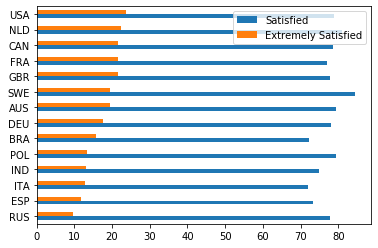

In [19]:
(100 * df_satisf.sort_values('Extremely Satisfied')).plot.barh()
plt.savefig('satisfaction.png')